In [1]:
# Importing some of the libraries
# Some were installed on the command prompt in requirements.txt

from PIL import Image
import pytesseract

In [2]:
# importing the prescription label image from a local folder

filepath = "resources/IMG-20231203-WA0010.jpg"
img = Image.open(filepath)

In [3]:
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1520x954 at 0x286008AF4C0>


In [4]:
img.show()

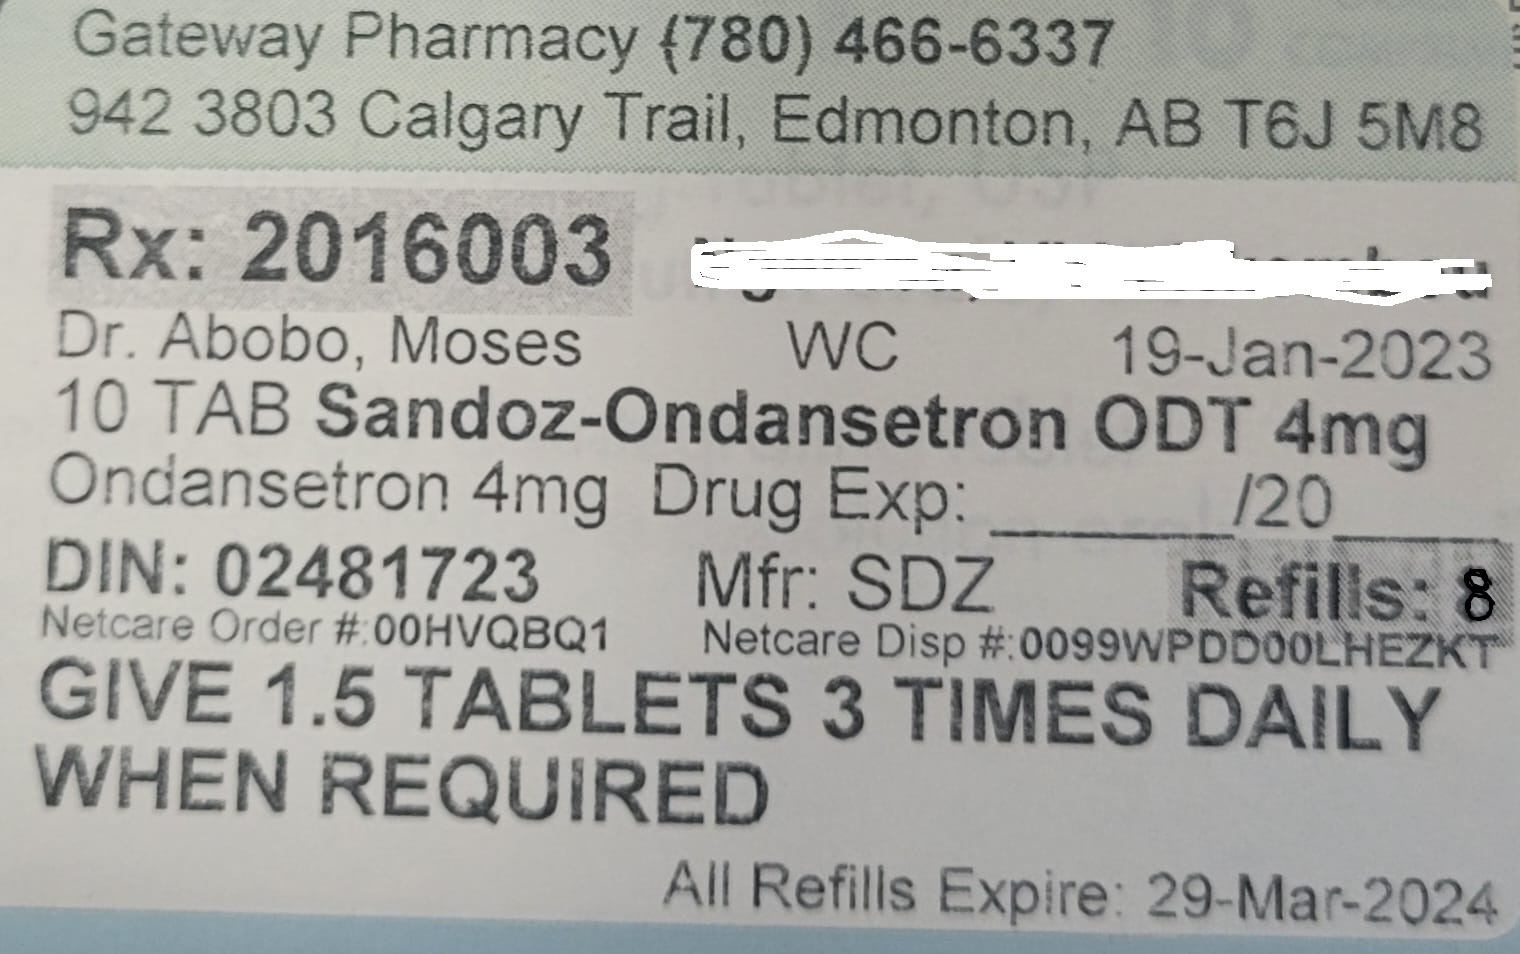

In [5]:
Image.open(filepath)

In [6]:
# converting image to text

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
text = pytesseract.image_to_string(img, lang='eng')
print(text)

Gateway Pharmacy {780) 466-6337 — :
942 3803 Calgary Trail, Edmonton, AB Tes SMB

Rx: 2016003 lee aa
Dr. Abobo, Moses WC 19. Jan-2023
10 TAB Sandoz- Ondansetron ODT 4mg

Ondansetron 4mg Drug Exp: == [20 Rte:

DIN: 02481723 Mfr: SDZ cosanseeil fi

etcare Order # OOHVQBQ1 Netcare Disp #:0099WPDDOOL

GIVE 1.5 TABLETS 3 TIMES See

WHEN REQUIRED
All Refills Expire: 29-Mar-2024



### Using computer vision to preprocess the image for better clarity

In [7]:
import cv2
import numpy as np

# creating a function that preprocesses the image
def preprocess_image(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)   #convert image(as a numpy array) from color to grayscale(0-255)
    resized = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR) # increase size of image by 1.5 so it is more visible
    processed_img = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 61, 11) #applying adaptive thresholding in OpenCV
    return processed_img

In [8]:
# applying the preprocessing function to the image

img_new = preprocess_image(img)

Image.fromarray(img_new).show()

In [9]:
# converting the preprocessed image to text with Tesseract
text = pytesseract.image_to_string(img_new, lang='eng')
print(text)

Gateway Pharmacy . {780). 466- -6337_
942 3803 Calgary Trail, Edmonton, AB Ted 5M8_

Rx: 2016003
Dr. Abobo. Moses ©

“WC 19-Jan-2023
10 TAB Sandoz-Ondansetron ODT 4mq

Ondansetron 4mg Drug Exo: [20
DIN: 02481723 Mfr: SDZ Refilis: 8

Netcare Order #:00HVQBQ1_—_—s Netcare Disp #:0099WPDDOOLHEZKT

GIVE 1.5 TABLETS 3 TIMES DAILY

WHEN REQUIRED
All Refills Expire: 29-Mar-2024




## Using Regular expression to extract the required info

In [10]:
import re

In [11]:
text = '''
Gateway Pharmacy . {780). 466- -6337_
942 3803 Calgary Trail, Edmonton, AB Ted 5M8_

Rx: 2016003
Dr. Abobo. Moses ©

“WC 19-Jan-2023
10 TAB Sandoz-Ondansetron ODT 4mq

Ondansetron 4mg Drug Exo: [20
DIN: 02481723 Mfr: SDZ Refilis: 8

Netcare Order #:00HVQBQ1_—_—s Netcare Disp #:0099WPDDOOLHEZKT

GIVE 1.5 TABLETS 3 TIMES DAILY

WHEN REQUIRED
All Refills Expire: 29-Mar-2024
'''

In [12]:
# Getting the prescription name (dot is any character, * means repeated many times)

pattern = '(.*)Drug'
matches = re.findall(pattern, text)
prescription = matches[0].strip()
prescription

'Ondansetron 4mg'

In [13]:
#Getting the dosage

pattern = 'Netcare[^\n]*(.*)All'
matches = re.findall(pattern, text, flags=re.DOTALL)
dosage = (matches[0].replace("GIVE", "TAKE")).strip().lower().replace('\n\n', ' ')
dosage

'take 1.5 tablets 3 times daily when required'

In [14]:
# Getting number of refills

pattern = 'Refilis:(.*)'
matches = re.findall(pattern, text)
refills = matches[0].strip()
refills

'8'

In [15]:
#Getting expiry date for refills

pattern = 'Refills.Expire:(.*)'
matches = re.findall(pattern, text)
expiry_date = matches[0].strip()
expiry_date

'29-Mar-2024'

In [16]:
message_text = f'Hello, as prescription for the drug {prescription}, {dosage}. It can be refilled {refills} times, on or before {expiry_date}'
message_text

'Hello, as prescription for the drug Ondansetron 4mg, take 1.5 tablets 3 times daily when required. It can be refilled 8 times, on or before 29-Mar-2024'

## Using Google cloud's wavenet text-to-speech API to generate the audio file

In [17]:
!pip install google-cloud-texttospeech

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import os

In [19]:
import google.cloud

In [20]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/amari/OneDrive/Documents/Data science projects/Prescription-Label-Reader/backend/centered-flow-407119-b4e5527bb781.json"


In [21]:
from google.cloud import texttospeech

In [22]:
# Instantiating a client 
client = texttospeech.TextToSpeechClient()

In [23]:
# Setting the input text to be synthesized

synthesis_input = texttospeech.SynthesisInput(text = message_text)

In [24]:
# Build the voice request, select language code and specify 'female' for ssml voice gender
voice = texttospeech.VoiceSelectionParams(language_code='en-US',
                                        name='en-US-wavenet-C',
                                        ssml_gender=texttospeech.SsmlVoiceGender.FEMALE)

In [25]:
# Select the type of audio file you want to return
audio_config = texttospeech.AudioConfig(audio_encoding=texttospeech.AudioEncoding.MP3)

In [26]:
# Perform the text-o-speech request on the text input with the selected voice parameters and audio file type

response = client.synthesize_speech(input=synthesis_input,
                                 voice=voice,
                                 audio_config=audio_config)

# writing the response to the output file
with open('output.mp3', 'wb') as out:
    out.write(response.audio_content)
print('Audio content written to output file "output.mp3"')

Audio content written to output file "output.mp3"
